## Airport Scheduling Problem 

### simplifying assumptions
- airport only "open" between 6:00 AM and 11:59 PM  


### Process Description 
* The airport environment is modelled as a Markov Decision Process, including
    * Stages / Time: $t$
        * Time steps in hours
        * $t = 0, 1, 2, ..., T$
    * States: $x_t$
        * Number of arriving passengers waiting in the queue (customs) given time step
        * $x_t = 0, 1, 2, ..., \text{waiting capacity}$
    * Actions: $u_t$
        * Number of on-demand customs officers to hire given time step
        * Is not defined for $t=T$ (airport closed)
        * $u_t = 0, 1, 2, ..., \text{max number of customs officers}$
    * Transitions: $f_t(x_t, u_t)$
        * Characterisation of state in next period
        * $x_{t+1}=f(x_t,u_t)=[x_t+d_t-2(u_t+10)]^+$
            * $d_t$ is the number of passengers arriving to customs area in the current hour
                * Follows:
                    * 1) the poisson distribution at t for a stochastic transition, where lambdas are modeled from historical data
                      2) a deterministic arrival schedule based on historical data
            * The formula assmued airport already has 2 permanent customs officers, and each doctor on average can treat 15 patients per hour
    * Costs: $g_t, g_T$
        * Cost per Stage: $g_t(x_t, u_t)$
            * If Cost of on-demand customs officer is 500/doc-hour; cost of one passenger waiting per hour is 30:
                * $g_t(x_t, u_t) = 500u_t + 30x_t$
        * Terminal Cost: $g_T(x_T)$
            * If there are still passengers waiting at the end of the day, the airport will incur a cost of 300 per passenger:
                * $g_T(x_T) = 300x_T$
            
    



### Here we solve the airport scheduling problem backward induction.


- Clinic opens at 8am, and closes at 8pm
- w = 200 (patient waiting cost, per patient per hour)
- W = 400 (abandonment cost of not treating a patient)
- wage = 500 per on-demand doctor per hour (there are 10 doctors already scheduled for each hour, and you can ignore their wage since that doesn't change the calculations)
- patient arrival process: at the beginning of every hour t, D_t patients arrive. All the D_t's are i.i.d. Poisson random variables with lambda = 5.
- The initial number of patient (x_1) is anywhere between 0 and 70. (Think of these patients as having arrived before 8am and been waiting)

In [1]:
'''
Building the Airport Environment
'''

from hospital_env import HospitalEnv as AirportEnv
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import poisson
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf')


### Based on historical data, set lambdas for morning, afternoon, evening

In [2]:
# Set the mean (lambda) for the Poisson distribution
lambda_morning = 6*[518] # 6AM-11AM
lambda_afternoon = 6*[868] # 12PM-5PM
lambda_evening = 6*[529] # 6PM - 11PM
lambda_night = 6*[50]

arrival_distrib = lambda_night+ lambda_morning + lambda_afternoon + lambda_evening

# arrival_distrib

print(len(arrival_distrib))

# arrival_distrib


24


## Parameterization

- **work hours:** 6AM - 11PM (inclusive) --> 18 working hours
- passenger waiting cost per hour --> 100
- booth cost per hour --> 500
- passenger queue capacity --> 2000
- max on demand booths --> 15
- passenger not attended by end of day cost --> 500
- cost if passenger can't be incuded in queue  (queue overflow) --> 500
- default queue length (queue at start of the day) --> 0


In [3]:
# Initialize the environment
arrival_distrib=arrival_distrib
open_time=6
work_hours=18
passenger_waiting_cost=500
booth_cost=100
boot_fixed_cost = 250
waiting_capacity=500
max_on_demand_booth=50 
passenger_not_attended_cost=1000
default_queue_length=0

# set up object 
airport_env = AirportEnv(arrival_distrib=arrival_distrib,
                         open_time=open_time,
                         work_hours=work_hours,
                         patient_waiting_cost=passenger_waiting_cost,
                         doc_cost=booth_cost,
                         waiting_capacity=waiting_capacity,
                         max_on_demand_doc=max_on_demand_booth,
                         patient_not_treated_cost=passenger_not_attended_cost,
                         default_queue_length=default_queue_length)

### Run the Stochastic Backward Induction Algorithm

In [4]:
'''
Run the Stochastic Backward Induction Algorithm
'''
from BI_solver_sto import BISolverSto

solver_sto = BISolverSto(env=airport_env)

In [5]:
'''
Run the Stochastic Backward Induction Algorithm
'''
policy_sto, cost_sto = solver_sto.backward_induction()



-----processing state 17
index process took: 67.98
-----processing state 16
index process took: 70.205
-----processing state 15
index process took: 76.936
-----processing state 14
index process took: 75.997
-----processing state 13
index process took: 77.765
-----processing state 12
index process took: 68.814
-----processing state 11
index process took: 82.641
-----processing state 10
index process took: 69.019
-----processing state 9
index process took: 79.711
-----processing state 8
index process took: 69.4
-----processing state 7
index process took: 92.153
-----processing state 6
index process took: 77.364
-----processing state 5
index process took: 81.812
-----processing state 4
index process took: 67.821
-----processing state 3
index process took: 85.155
-----processing state 2
index process took: 72.004
-----processing state 1
index process took: 78.801
-----processing state 0
index process took: 71.69


In [11]:
# save policy as df
pd.DataFrame(policy_sto).to_csv("optimal_policy.csv")
# save cost to go as df 
pd.DataFrame(cost_sto).to_csv("optimal_ctg.csv")

## Optimal Policy Visualized

In [8]:
# pd.DataFrame(policy_sto)

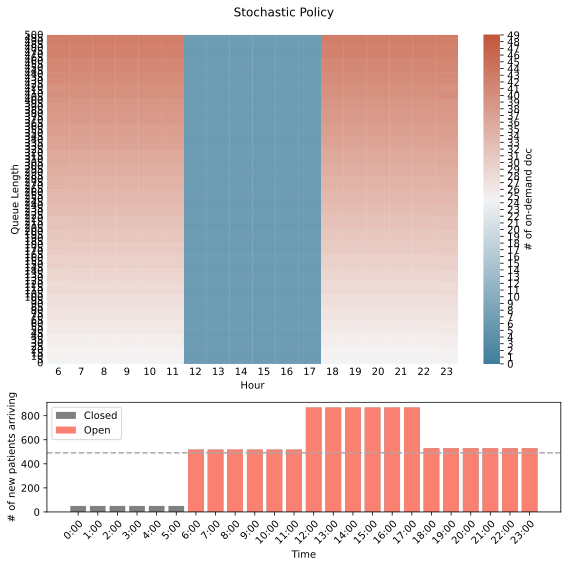

In [6]:
airport_env.visualize_policy(policy_sto, "Stochastic Policy")

##  cost-to-go: Summarizing Optimal Policy wrt Cost

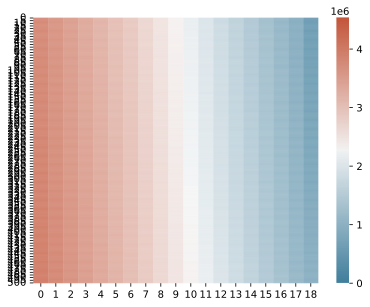

In [9]:
heatmap = sns.heatmap(cost_sto, 
                      cmap=sns.diverging_palette(230, 20, as_cmap=True),
                      yticklabels=5
                      )

## Apply optimal policy to real world data - What Cost Would the Terminal have Incurred from running this policy over the course of 2023?

In [ ]:
def simulate_real(policy, env, arrival_dist_set):
    '''
    Simulate the environment with the given policy,
    the policy must be a discrete table.

    Return the average cost
    '''
    print(f"[ Simulating for {len(arrival_dist_set)} episodes... ]")

    total_cost = 0

    # Simulate the environment for num_sim times
    for arr in arrival_dist_set:
        # Reset the environment
        x_t, _ = env.reset()
        # overwrite arriaval dist
        env.arrival_dist = arr
        # set other vars
        cost, done, t = 0, False, 0
        # Iterate through all time steps
        while not done:
            # Take the action given by the policy
            u_t = policy[x_t][t]
            # Take a step in the environment
            (x_t, _), step_cost, done = env.step(u_t)
            cost += step_cost
            t += 1
        # Add the cost
        total_cost += cost

    return total_cost / num_sim

In [ ]:
# extract hourly arrivals for every day in 2022

# reset airport env to detemrinistic and overwrite arrival dist with real data



In [ ]:
# simulate outcome if optimal policy was applied in 2022